In [5]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sn
import utils
from joblib import dump, load
from matplotlib import colors
from osgeo import gdal
from skimage import exposure
from skimage.util import img_as_ubyte
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import time
import matplotlib

In [ ]:
#get file directory

import os
current_directory = os.getcwd()
print(current_directory)

## Image Pre-processing Steps: Manual Classification

I need to create a reference dataset for training and evaluation of the ML algorithm. This is achieved by manually classifying a selection of images, and then using some of them for training and some for evaluation. 

- In ArcPro, I manually digitized small subsets of the entire drone image with the following land cover classes: 

     
| Classification Schema | Severity Ranking | 
| --- | --- |
| Green Vegetation | 1 - Low Severity |
| Bare Soil | 1 - Low Severity |
| Burnt Woody Vegetation (Standing) | 2 - Med Severity |
| Gray Ash | 3 - High Severity |
| Charred Soil/Grass | 3 - High Severity |
| Charred Woody | 3 - High Severity |
| White Ash | 4 - Total Combustion |

- Once the model is running, the land cover classifications will be reclassified to their correlating burn severity ranking for the final classification map.


- Shadow was also manually classified, but does not correlate to a burn severity classification, and can therefore be thought of an Null for this project.


- I have two manually digitized images (area1_manual & area2_manual) that will be used to train the model, and then the entire drone image(raw_img) will be used as the test image.


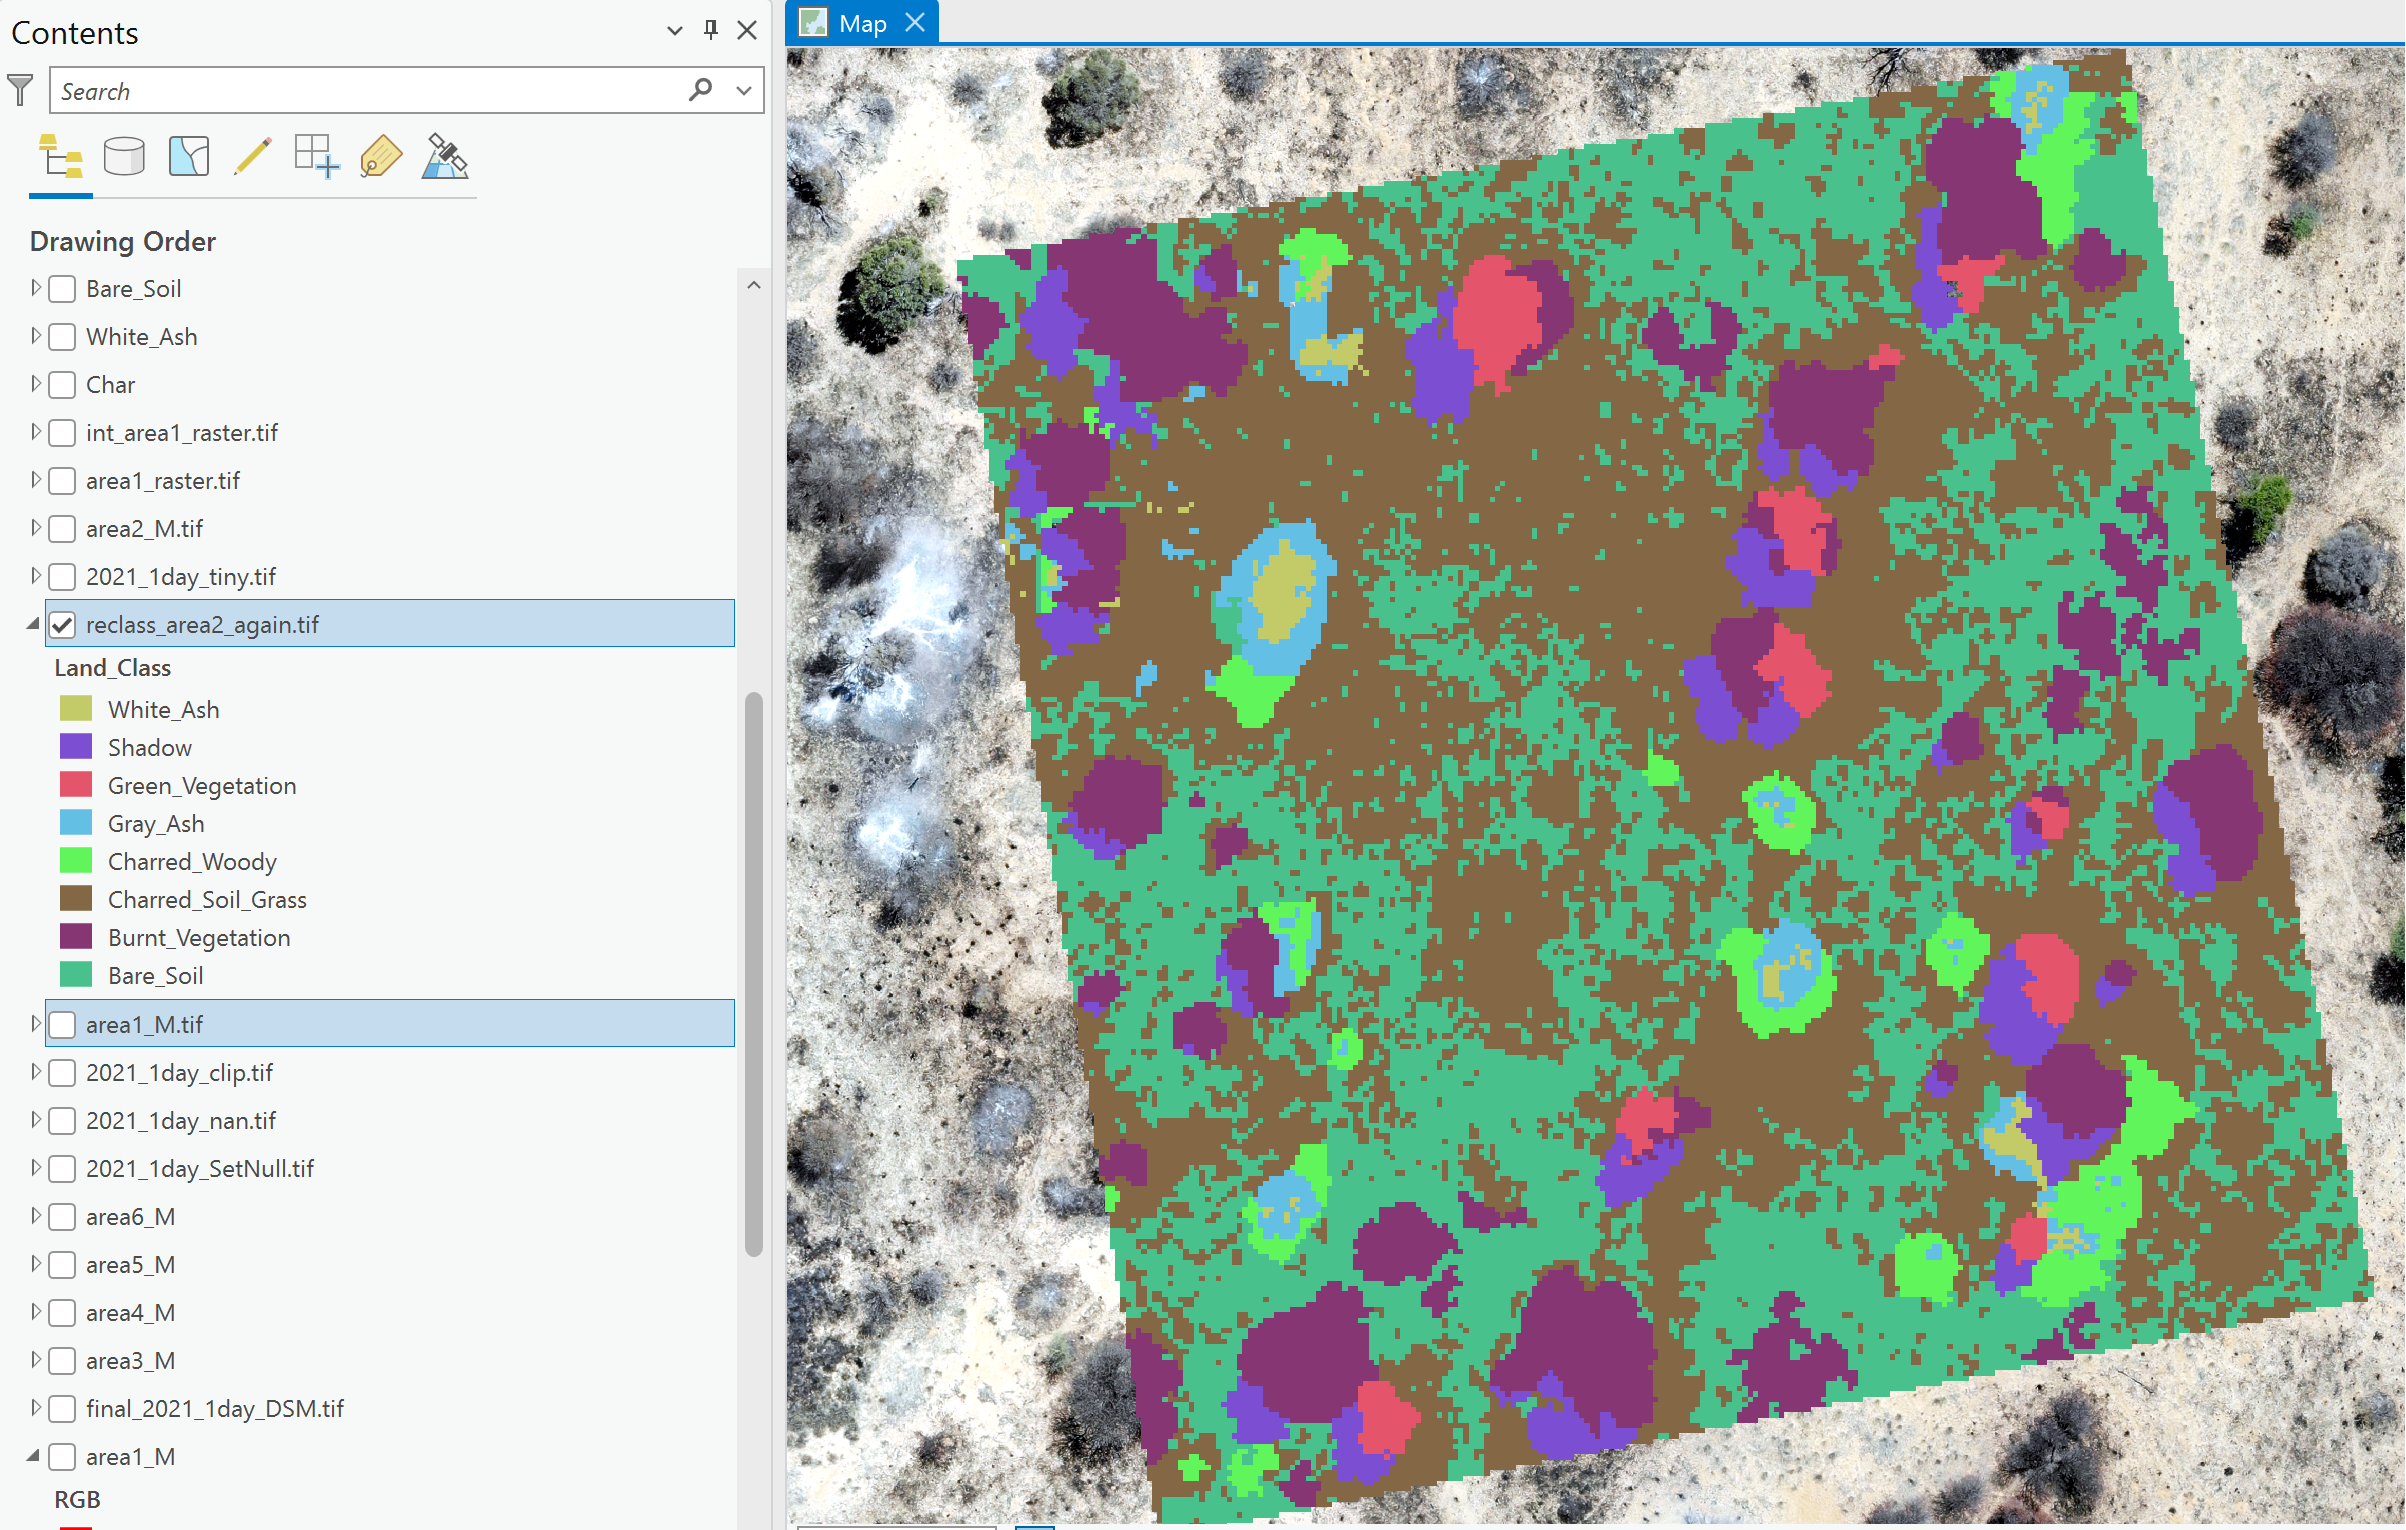

## Equalize Test Drone Image
- Read in the inital RGB image and equalize it to create a stronger contrast that allows for easier classification. Mask all no-data values.
- This equalized image will be used to test the model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


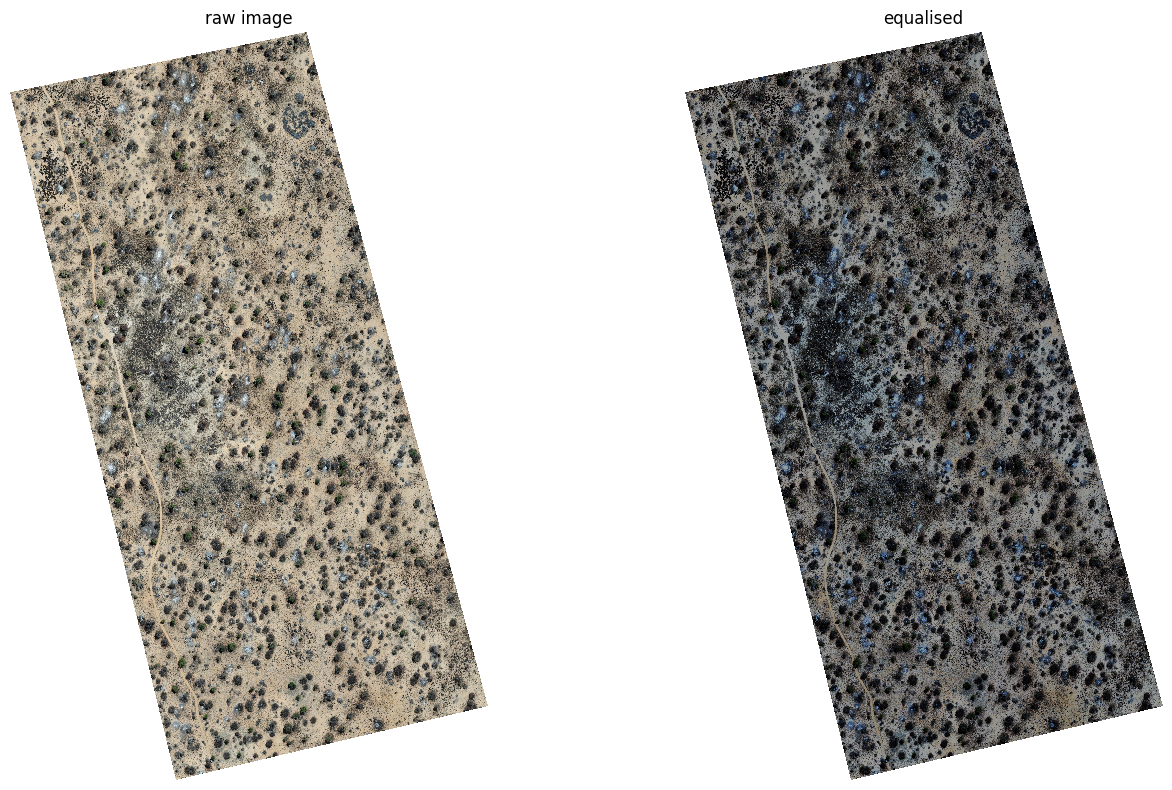

In [43]:
# Path to image
raw_path = r'C:\Users\gille\Desktop\Masters_Drone\2021_1day_tiny.tif'

import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal

ds = gdal.Open(raw_path, gdal.GA_ReadOnly)
raw_img = ds.ReadAsArray().transpose((1, 2, 0))
ds_array[ds_array == 65535] = 0

#equalize
band1_eq = img_as_ubyte(exposure.equalize_hist(raw_img[:, :, 0]))
band2_eq = img_as_ubyte(exposure.equalize_hist(raw_img[:, :, 1]))
band3_eq = img_as_ubyte(exposure.equalize_hist(raw_img[:, :, 2]))

raw_img_eq = np.dstack((band1_eq, band2_eq, band3_eq))

#Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Raw image
axes[0].imshow(raw_img, interpolation="none")
axes[0].set_title(f"raw image", fontsize=12)

#Equalised image
axes[1].imshow(raw_img_eq, interpolation="none")
axes[1].set_title(f"equalised", fontsize=12)

# plt.imshow(ds_array[:, :, 0:3])
# Turn off axes
axes[0].axis("off")
axes[1].axis("off")

plt.tight_layout()

## Visualize drone imagery vs. the manual burn severity classifications 

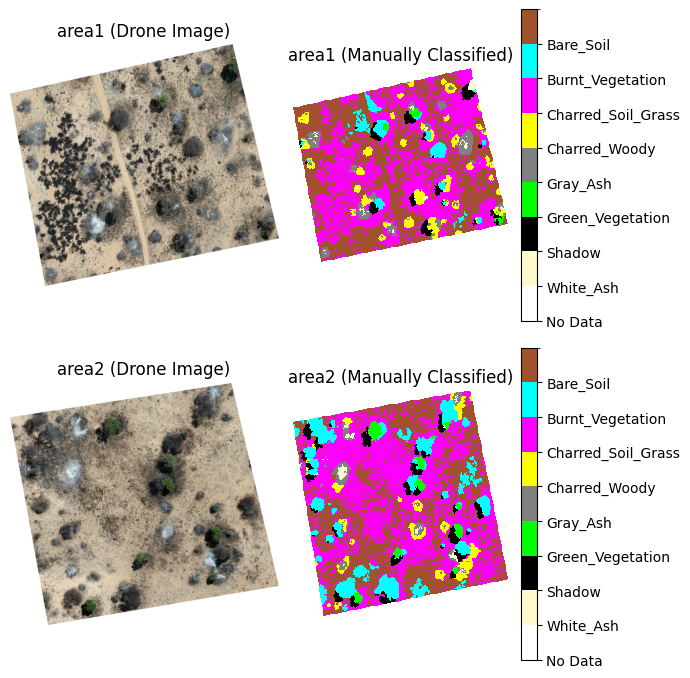

In [57]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import rasterio

# Setup plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

# Class Codes
class_codes = {
    0: "No Data",
    1: "White_Ash",
    2: "Shadow",
    3: "Green_Vegetation",
    4: "Gray_Ash",
    5: "Charred_Woody",
    6: "Charred_Soil_Grass",
    7: "Burnt_Vegetation",
    8: "Bare_Soil",
    15: "NoData"
}

# Color Map
cmap = colors.ListedColormap(
    ["white", "lemonchiffon", "black", "lime", "grey", "yellow", "magenta", "aqua", "sienna"],
    N=len(class_codes) - 1  # Exclude the last color for NoData
)

# BoundaryNorm for discrete colors
norm = colors.BoundaryNorm(boundaries=np.arange(0, len(class_codes)), ncolors=len(class_codes))

# Manually classified image names
fnames = ["area1", "area2"]

# Loop over data
for idx, name in enumerate(fnames):
    # Paths to images
    raw_path = r"C:\Users\gille\Desktop\Masters_Drone\%s_raw_y.tif" % name
    man_path = r"C:\Users\gille\Desktop\Masters_Drone\%s_manual.tif" % name

    # Read raw bands to arrays
    with rasterio.open(raw_path) as src:
        # Read each band separately
        band1 = src.read(1)
        band2 = src.read(2)
        band3 = src.read(3)

        # Get nodata value, EPSG code, and extent
        ndv = src.nodata
        epsg = src.crs.to_epsg() if src.crs else None
        extent = src.bounds

        # Stack the bands using numpy
        raw_img_area = np.dstack((band1, band2, band3))

    with rasterio.open(man_path) as src:
        # Read the single band
        man_img_area = src.read(1)

        # Get nodata value, EPSG code, and extent
        ndv = src.nodata
        man_epsg = src.crs.to_epsg() if src.crs else None
        extent = src.bounds

    # NaN changed to float
    man_img_area = man_img_area.astype(np.float64)

    a = man_img_area
    man_img_area = np.ma.array(a, mask=np.isnan(a))

    # Plot
    # Raw image
    raw_img_area[raw_img_area == 0] = 255
    axes[idx, 0].imshow(raw_img_area)
    axes[idx, 0].set_title("%s (Drone Image)" % name, fontsize=12)

    # Manually classified using imshow
    man_img_area[man_img_area == 15] = 0  # Set NoData to the first color (yellow) in the color map
    img = axes[idx, 1].imshow(man_img_area, cmap=cmap, norm=norm, interpolation='none')
    axes[idx, 1].set_title("%s (Manually Classified)" % name, fontsize=12)

    # Turn off axes
    axes[idx, 0].axis("off")
    axes[idx, 1].axis("off")

    # Colorbar for manual dataset
    cb = plt.colorbar(img, ax=axes[idx, 1], ticks=np.arange(0, len(class_codes) - 1), boundaries=np.arange(0, len(class_codes)))
    cb.set_ticklabels(list(class_codes.values())[:-1])  # Exclude the last label (NoData)

plt.tight_layout()
plt.show()
 

## Training the model:
- I am first resampling the images (raw and manually classified) to ensure that they all have the same dimensions.
- I will take a standard ML approach and split the data into three portions: one for training, one for evaluation and a third for testing. I will split the data as follows: 
    - Data from the first two images (area1_raw & area2_raw) will be pooled, and then split 60:40 at random to create the training and evaluation datasets, respectively. 
    - The third image (raw_img_eq - the entire drone image) is withheld as a completely independent image for testing the fitted algorithm at the end of the process.


### Creating Training & Evaluation Datasets

In [ ]:
#Resample manual class image to match RGB

#area 1

import rasterio
from rasterio.enums import Resampling

def resample_raster(input_path, output_path, target_height, target_width):
    with rasterio.open(input_path) as src:
        transform = src.transform
        profile = src.profile
        profile.update(width=target_width, height=target_height, transform=transform)

        data = src.read(
            out_shape=(src.count, target_height, target_width),
            resampling=Resampling.bilinear
        )

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data)

# Paths to images
raw_path_area1 = r'C:\Users\gille\Desktop\Masters_Drone\area1_raw.tif'
man_path_area1 = r'C:\Users\gille\Desktop\Masters_Drone\area1_manual.tif'

output_man_class_path_area1 = r'C:\Users\gille\Desktop\Masters_Drone\output_man_class_area1.tif'


raw_path_area2 = r'C:\Users\gille\Desktop\Masters_Drone\area2_raw.tif'
man_path_area2 = r'C:\Users\gille\Desktop\Masters_Drone\area2_manual.tif'

output_man_class_path_area2 = r'C:\Users\gille\Desktop\Masters_Drone\output_man_class_area2.tif'

# Read the raw RGB image to get its shape
with rasterio.open(raw_path_area1) as raw_src:
    target_height, target_width = raw_src.shape

# Resample manually classified image to match dimensions of the RGB image

#area 1
resample_raster(man_path_area1, output_man_class_path_area1, target_height, target_width)

#area 2
resample_raster(man_path_area2, output_man_class_path_area2, target_height, target_width)

In [52]:
#Resample Area 2 RGB to match Area 1 RGB 

def resample_rgb(input_path, output_path, target_height, target_width):
    with rasterio.open(input_path) as src:
        transform = src.transform
        profile = src.profile
        profile.update(width=target_width, height=target_height, transform=transform)

        data = src.read(
            out_shape=(src.count, target_height, target_width),
            resampling=Resampling.nearest  # Use nearest-neighbor resampling to maintain original pixel values
        )

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data)

# Paths to images
raw_path_area2 = r'C:\Users\gille\Desktop\Masters_Drone\area2_raw.tif'

output_rgb_resampled_area2 = r'C:\Users\gille\Desktop\Masters_Drone\output_rgb_resampled_area2.tif'

# Resample the RGB image of area 2 to match the dimensions of area 1
resample_rgb(raw_path_area2, output_rgb_resampled_area2, target_height, target_width)


In [ ]:
#File breakdowns:

#area1_raw_y : OG RGB image for area 1 
#area2_raw_y : resampled RGB image for area 2 (resampled to match size of area)
#area1_manual_rclass : reclassified manual image to match size of RGB
#area2_manual_rclass : reclassified manual image to match size of RGB

In [3]:
import rasterio
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Containers for data
y_list = []
r_list = []
g_list = []
b_list = []

# Loop over data for images 1 and 2
for name in fnames[:2]:
    # Paths to images
    raw_path = r'C:\Users\gille\Desktop\Masters_Drone\%s_raw_y.tif' % name
    man_path = r'C:\Users\gille\Desktop\Masters_Drone\%s_manual_rclass.tif' % name
    
    # Read raw bands to arrays using rasterio
    with rasterio.open(raw_path) as src:
        band1 = src.read(1)
        band2 = src.read(2)
        band3 = src.read(3)
    
    # Read manually classified data (1 band only) using rasterio
    with rasterio.open(man_path) as src:
        man_img = src.read(1)
    
    # Flatten to 1D and append all pixels
    y_list.append(man_img.flatten())
    r_list.append(band1.flatten())
    g_list.append(band2.flatten())
    b_list.append(band3.flatten())

    # Print lengths for debugging
    print(f"Length of y_list: {len(y_list[-1])}")
    print(f"Length of r_list: {len(r_list[-1])}")
    print(f"Length of g_list: {len(g_list[-1])}")
    print(f"Length of b_list: {len(b_list[-1])}")

# Concatenate to a single dataset
y = np.concatenate(y_list)
r = np.concatenate(r_list)
g = np.concatenate(g_list)
b = np.concatenate(b_list)

# Build dataframe
df = pd.DataFrame({'y': y, 'r': r, 'g': g, 'b': b})

# Split into training and evaluation
X_train, X_eval, y_train, y_eval = train_test_split(
    df[['r', 'g', 'b']],
    df['y'],
    test_size=0.4,
    random_state=42
)

# Checking
assert len(X_train) == len(y_train)
assert len(X_eval) == len(y_eval)
print('Number of training samples:  ', len(X_train))

Length of y_list: 7332772
Length of r_list: 7332772
Length of g_list: 7332772
Length of b_list: 7332772
Length of y_list: 7332772
Length of r_list: 7332772
Length of g_list: 7332772
Length of b_list: 7332772
Number of training samples:   8799326


### Training & Prediction

In [6]:
%%time

# Fit classifier to training data
classifier = RandomForestClassifier(n_jobs=-1, n_estimators=10)
classifier.fit(X_train, y_train)

CPU times: total: 4min 50s
Wall time: 58.3 s


RandomForestClassifier(n_estimators=10, n_jobs=-1)

In [7]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

RandomForestClassifier(max_features='auto', n_estimators=10, n_jobs=-1)

In [8]:
%%time

# Predict classes for remaining 40% of data
preds = classifier.predict(X_eval)

CPU times: total: 29.9 s
Wall time: 6.31 s


### Evaluation of the Model

In [30]:
# Only use relevant labels from the training dataset
class_labels = [1, 2, 3, 4, 5, 6, 7, 8]
target_names = [class_codes[i] for i in class_labels]

# Print metrics
print("Classification report:\n%s" %
      metrics.classification_report(y_eval, preds, 
                                    labels=class_labels, 
                                    target_names=target_names))

print("Classification accuracy: %f" %
      metrics.accuracy_score(y_eval, preds))

Classification report:
                    precision    recall  f1-score   support

         White_Ash       0.49      0.38      0.42     20514
            Shadow       0.67      0.43      0.52    127851
  Green_Vegetation       0.74      0.49      0.59     76469
          Gray_Ash       0.58      0.49      0.53    134476
     Charred_Woody       0.39      0.18      0.25    224694
Charred_Soil_Grass       0.62      0.77      0.69   1595044
  Burnt_Vegetation       0.47      0.13      0.21    748384
         Bare_Soil       0.68      0.84      0.75   1359253

         micro avg       0.63      0.62      0.63   4286685
         macro avg       0.58      0.46      0.50   4286685
      weighted avg       0.60      0.62      0.59   4286685

Classification accuracy: 0.725526


### Breakdown of the stats above:

Precision (P) is defined as the number of true positives (Tp) over the number of true positives plus the number of false positives (Fp).

- **Precision is the ability of the classifier not to label as positive a sample that is negative.**

Recall (R) is defined as the number of true positives (Tp) over the number of true positives plus the number of false negatives (Fn).

- **Recall is the ability of the classifier to find all the positive samples.**

These quantities are also related to the F1 score, which is defined as the harmonic mean of precision and recall.

For each class, it gives an overall indication of performance, where precision and recall are weighted equally.

In [31]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap='coolwarm'):

    import itertools
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.6)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

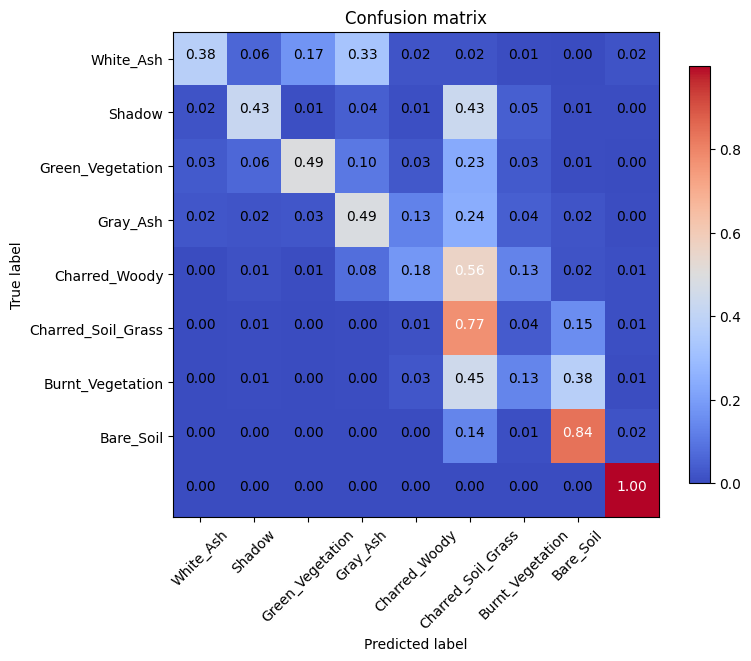

In [32]:
# Confusion matrix    
fig = plt.figure(figsize=(8,8))
fig.add_subplot(111)
cm = metrics.confusion_matrix(y_eval, preds)
plot_confusion_matrix(cm, classes=target_names, normalize=True)

## Predictions with the test (entire) image!


In [12]:
import rasterio
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Path to the new test image
new_test_image_path = r'C:\Users\gille\Desktop\Masters_Drone\2021_1day_tiny.tif'

# Container for data
data_dict_test = {}

with rasterio.open(new_test_image_path) as src:
    for band in range(1, 4):
        data = src.read(band)
        data_dict_test[str(band)] = data.flatten()

# Build DataFrame for the new test image
df_test = pd.DataFrame(data_dict_test)
del data_dict_test

df_test.reset_index(inplace=True, drop=True)

# Rename columns to match the names used during training
df_test.columns = ['r', 'g', 'b']

# Set chunk size for processing
chunk_size = 1000000

# Split DataFrame into chunks
chunks = np.array_split(df_test, len(df_test) // chunk_size + 1)

chunk_res = []

for chunk in chunks:
    # Make predictions on the test data chunk
    chunk_res.append(classifier.predict(chunk[['r', 'g', 'b']]))

# Concatenate predictions from all chunks
all_preds = np.concatenate(chunk_res)

# Print predictions for the new test image
print('Predictions for the new test image:', all_preds)

C:\Users\gille\anaconda3\envs\Py310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Predictions for the new test image: [1 1 1 ... 1 1 1]


## Visualize the model predicted classification map: 

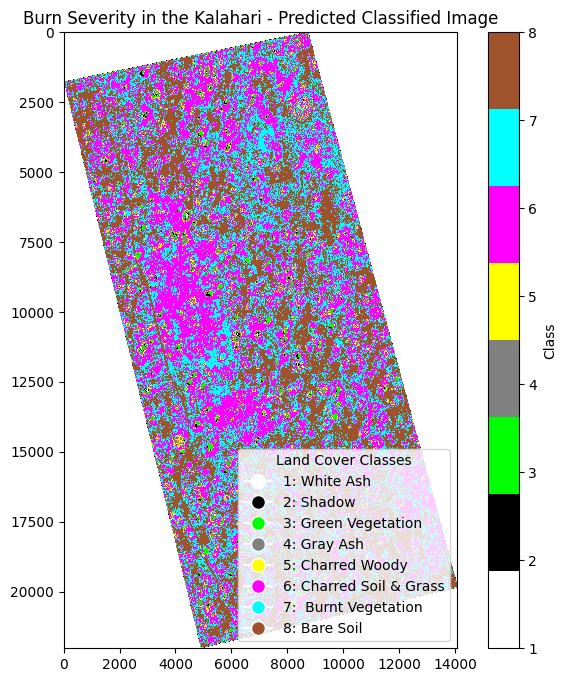

In [56]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Path to the test image
test_image_path = r'C:\Users\gille\Desktop\Masters_Drone\2021_1day_tiny.tif'

# Define the class labels and their corresponding names
class_labels = [1, 2, 3, 4, 5, 6, 7, 8]
class_names = ['White Ash', 'Shadow', 'Green Vegetation', 'Gray Ash', 'Charred Woody', 'Charred Soil & Grass', ' Burnt Vegetation', 'Bare Soil']

# Load the predicted classes for the test image
with rasterio.open(test_image_path) as src:
    height, width = src.shape
    pred_image = all_preds.reshape((height, width))

# Create a custom colormap for visualization
colors =   ["white", "black", "lime", "grey", "yellow", "magenta", "aqua", "sienna"]
cmap = ListedColormap(colors)

# Plot the predicted classified image
plt.figure(figsize=(8, 8))
img = plt.imshow(pred_image, cmap=cmap, vmin=1, vmax=8)  # Adjust vmin and vmax based on your class labels
plt.title('Burn Severity in the Kalahari - Predicted Classified Image')
plt.colorbar(ticks=range(1, 9), label='Class')

# Add a legend
legend_labels = [f'{label}: {name}' for label, name in zip(class_labels, class_names)]
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                    for label, color in zip(legend_labels, colors)],
           title='Land Cover Classes', loc='lower right')

# Show the plot
plt.show()

## Lastly, let's reclassify the final image to correlate the land class to its burn severity ranking.

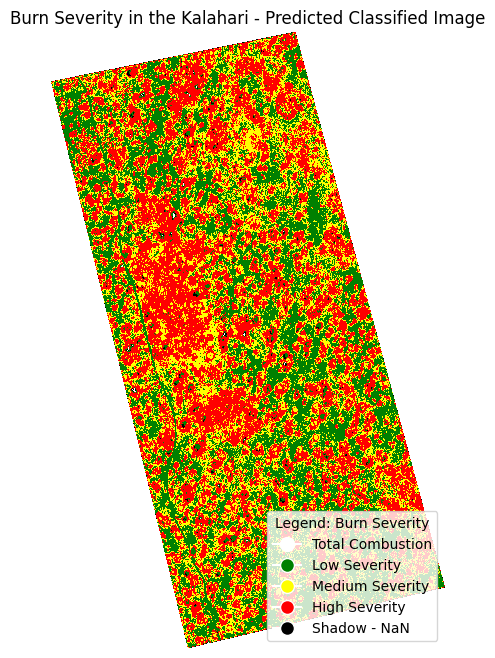

In [52]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Path to the test image
test_image_path = r'C:\Users\gille\Desktop\Masters_Drone\2021_1day_tiny.tif'

# Load the predicted classes for the test image
with rasterio.open(test_image_path) as src:
    height, width = src.shape
    pred_image = all_preds.reshape((height, width))

# Create a custom colormap for visualization
colors = ["white", "black", "green", "red", "red", "red", "yellow", "green"]
cmap = ListedColormap(colors)

# Plot the predicted classified image
plt.figure(figsize=(8, 8))
img = plt.imshow(pred_image, cmap=cmap, vmin=1, vmax=8)  # Adjust vmin and vmax based on your class labels
plt.title('Burn Severity in the Kalahari - Predicted Classified Image')

# Manually set legend labels and colors
legend_labels = ['Total Combustion', 'Low Severity', 'Medium Severity', 'High Severity', 'Shadow - NaN']
legend_colors = ['white', 'green', 'yellow', 'red', 'black']

# Create a manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                  for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='Legend: Burn Severity', loc='lower right')

# Hide the axes
plt.axis('off')

# Show the plot
plt.show()